This notebook shows the effect of systematically overestimating or underestimating the optimal HFX by some amount, using both the data from the original DFA recommender paper (VSS-452 and CSD-76) as well as the data sets developed in this work (VSS-452-HFX and CSD-76-HFX).

# For VSS-452 and CSD-76

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.interpolate import interp1d
from scipy.optimize import minimize
from tqdm import tqdm

vss_df = pd.read_csv('../data/VSS-452.csv').set_index('name')
csd_df = pd.read_csv('../data/CSD-76.csv').set_index('name')
to_remove = []
for idx, row in csd_df.iterrows():
    if 'Cr' in idx:
        to_remove.append(idx)
csd_df = csd_df.drop(to_remove)

functionals = ['blyp', 'pbe', 'scan', 'm06-l', 'mn15-l']
hfx_amounts = ['10', '20', '30', '40', '50']

csd_opt = {f: {} for f in functionals}
vss_opt = {f: {} for f in functionals}

for base_functional in functionals:
    for idx, df in enumerate([csd_df, vss_df]):
        errors = []
        for name, row in df.iterrows():
            optimal_vsse = row['dlpno-CCSD_T.vertsse']
            hfxs = []
            vsses = []
            if not np.isnan(row[f'{base_functional}.vertsse']):
                hfxs.append(0)
                vsses.append(row[f'{base_functional}.vertsse'])
            for hfx in hfx_amounts:
                functional = base_functional + '_hfx_' + hfx
                if not np.isnan(row[f'{functional}.vertsse']):
                    hfxs.append(int(hfx))
                    vsses.append(row[f'{functional}.vertsse'])
            fit = interp1d(hfxs, vsses, kind='linear', fill_value='extrapolate')
            sse_intersection = lambda hfx: (fit(hfx) - optimal_vsse)**2
            res = minimize(sse_intersection, 25, method='Nelder-Mead')
            if res.success:
                hfx = res.x[0]
                if idx == 0:
                    csd_opt[base_functional][name] =  hfx
                else:
                    vss_opt[base_functional][name] = hfx

In [2]:
def AE_sys_error(dataset, offset):

    def pred_energy(structure, functional, dataset):
        if dataset == 'csd':
            df = csd_df
            preds = csd_opt
        elif dataset == 'vss':
            df = vss_df
            preds = vss_opt
        else:
            raise ValueError("Specify a valid dataset!")
        pred_hfx = preds[functional][structure]
        pred_hfx += offset
        for idx, pred in enumerate(pred_hfx):
            if pred > 50:
                pred_hfx[idx] = 50
            elif pred < 0:
                pred_hfx[idx] = 0
        
        hfxs = []
        vsses = []
        if not np.isnan(df.loc[structure][f'{functional}.vertsse']):
            hfxs.append(0)
            vsses.append(df.loc[structure][f'{functional}.vertsse'])
        for hfx in hfx_amounts:
            functional2 = functional + '_hfx_' + hfx
            if not np.isnan(df.loc[structure][f'{functional2}.vertsse']):
                hfxs.append(int(hfx))
                vsses.append(df.loc[structure][f'{functional2}.vertsse'])
        line = interp1d(hfxs, vsses, kind='linear', fill_value='extrapolate')
        return line(pred_hfx)

    if dataset == 'csd':
        df = csd_df
    elif dataset == 'vss':
        df = vss_df

    blyp_errors = []
    pbe_errors = []
    scan_errors = []
    m06l_errors = []
    mn15l_errors = []

    for struct in tqdm(df.index.to_list()):
        if dataset == 'csd':
            reference = csd_df.loc[struct]['dlpno-CCSD_T.vertsse']
        elif dataset == 'vss':
            reference = vss_df.loc[struct]['dlpno-CCSD_T.vertsse']
        else:
            raise ValueError('Provide a proper reference')
        blyp_energy = pred_energy(struct, 'blyp', dataset)
        if blyp_energy is not None:
            blyp_errors.append(reference-blyp_energy)
        pbe_energy = pred_energy(struct, 'pbe', dataset)
        if pbe_energy is not None:
            pbe_errors.append(reference - pbe_energy)
        scan_energy = pred_energy(struct, 'scan', dataset)
        if scan_energy is not None:
            scan_errors.append(reference-scan_energy)
        m06l_energy = pred_energy(struct, 'm06-l', dataset)
        if m06l_energy is not None:
            m06l_errors.append(reference-m06l_energy)
        mn15l_energy = pred_energy(struct, 'mn15-l', dataset)
        if mn15l_energy is not None:
            mn15l_errors.append(reference-mn15l_energy)

    return np.abs(np.array(blyp_errors)), np.abs(np.array(pbe_errors)), np.abs(np.array(scan_errors)), np.abs(np.array(m06l_errors)), np.abs(np.array(mn15l_errors))

100%|██████████████████████████████████████████| 72/72 [00:00<00:00, 230.97it/s]


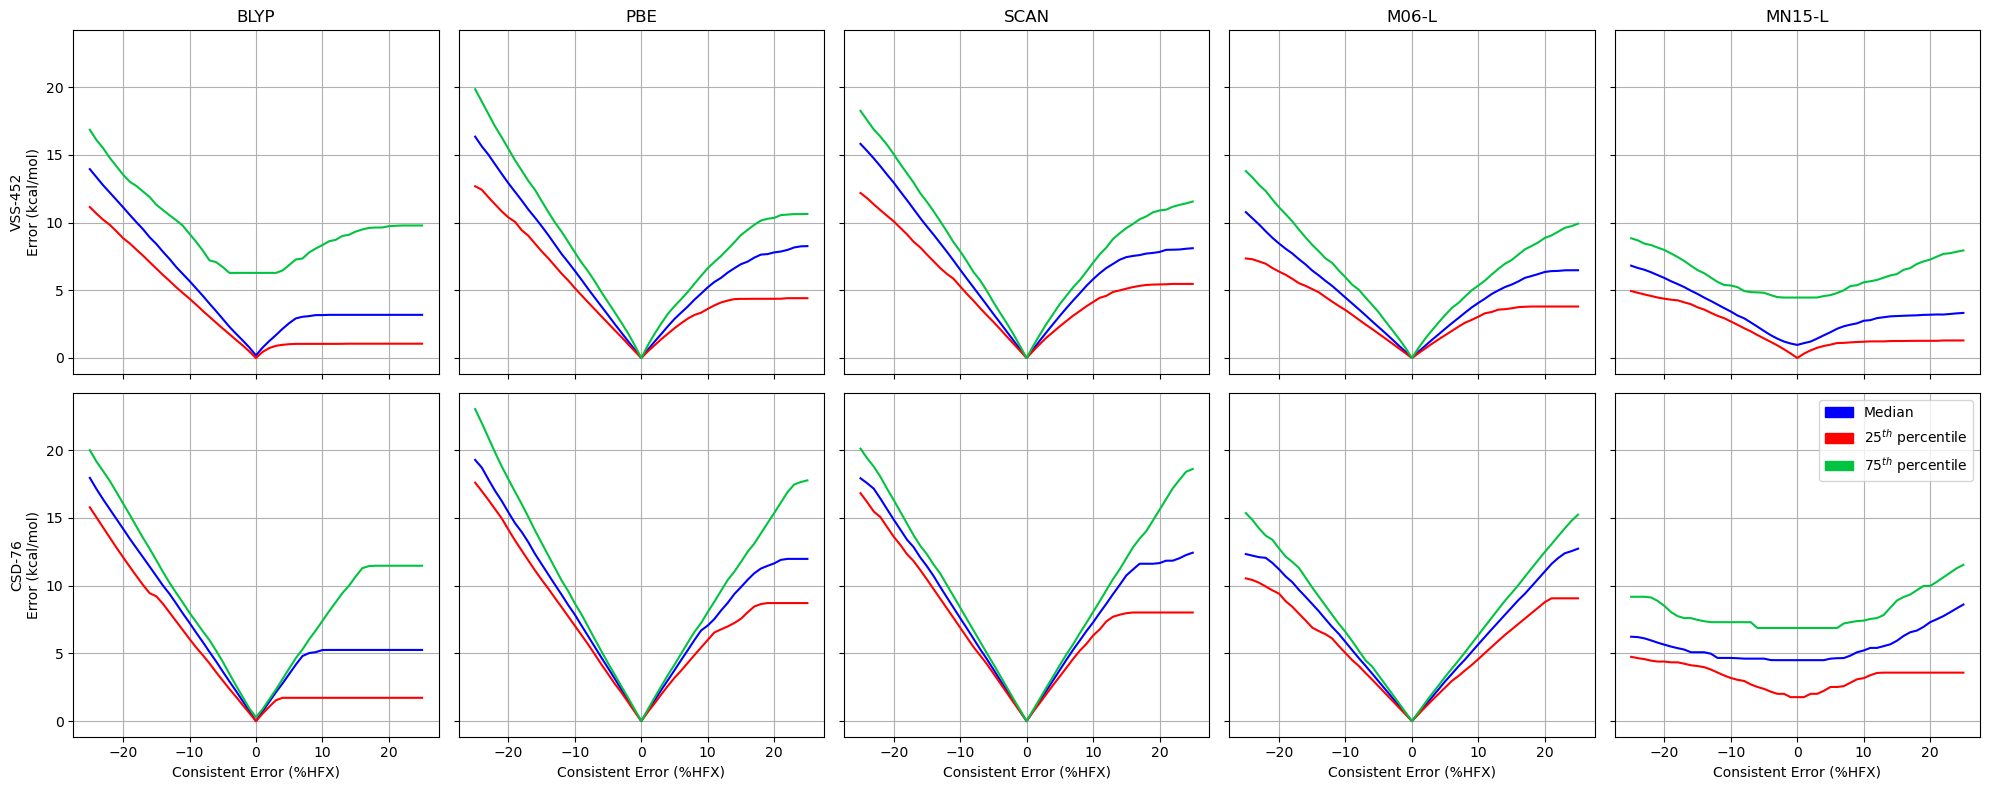

In [3]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(20, 8), sharex=True, sharey=True)

minnum = -25
maxnum = 25
errrange = np.arange(minnum, maxnum+1, 1)

for i in range(5):
    ax[0,i].plot(errrange, np.median(AE_sys_error('vss', errrange)[i], axis=0), color='#0000FF')
    ax[0,i].plot(errrange, np.quantile(AE_sys_error('vss', errrange)[i], 0.25, axis=0), color='#FF0000')
    ax[0,i].plot(errrange, np.quantile(AE_sys_error('vss', errrange)[i], 0.75, axis=0), color='#00C440')
    ax[0,i].grid()

    ax[1,i].plot(errrange, np.median(AE_sys_error('csd', errrange)[i], axis=0), color='#0000FF')
    ax[1,i].plot(errrange, np.quantile(AE_sys_error('csd', errrange)[i], 0.25, axis=0), color='#FF0000')
    ax[1,i].plot(errrange, np.quantile(AE_sys_error('csd', errrange)[i], 0.75, axis=0), color='#00C440')
    ax[1,i].grid()

ax[0,0].set_title('BLYP')
ax[0,1].set_title('PBE')
ax[0,2].set_title('SCAN')
ax[0,3].set_title('M06-L')
ax[0,4].set_title('MN15-L')
ax[0,0].set_ylabel('VSS-452\nError (kcal/mol)')
ax[1,0].set_ylabel('CSD-76\nError (kcal/mol)')
ax[1,0].set_xlabel('Consistent Error (%HFX)')
ax[1,1].set_xlabel('Consistent Error (%HFX)')
ax[1,2].set_xlabel('Consistent Error (%HFX)')
ax[1,3].set_xlabel('Consistent Error (%HFX)')
ax[1,4].set_xlabel('Consistent Error (%HFX)')

import matplotlib.patches as mpatches
patch0 = mpatches.Patch(color='#0000FF', label='Median')
patch1 = mpatches.Patch(color='#FF0000', label=r'25$^{th}$ percentile')
patch2 = mpatches.Patch(color='#00C440', label=r'75$^{th}$ percentile')
ax[1,4].legend(handles=[patch0, patch1, patch2])

fig.tight_layout()

# For VSS-452-HFX and CSD-76-HFX

In [4]:
import numpy as np
from scipy.interpolate import CubicSpline, interp1d
import matplotlib.pyplot as plt
import os
import pandas as pd
from tqdm import tqdm, trange
import json
from scipy.optimize import minimize

csd_sse_df = pd.read_csv('../data/cleaned_csd76_sse.csv').set_index('Unnamed: 0')

csd_hfx_df = pd.read_csv('../data/CSD76targets.csv').set_index('Unnamed: 0').clip(lower=0, upper=100)

csd_76 = pd.read_csv('../data/CSD-76.csv').set_index('name')

vss_sse_df = pd.read_csv('../data/cleaned_vss452_sse.csv').set_index('Unnamed: 0')
names = {}
for name in vss_sse_df.index:
    elems = name.split('/')
    names[name] =elems[-1]
vss_sse_df = vss_sse_df.rename(index=names)

vss_hfx_df = pd.read_csv('../data/VSS452targets.csv').set_index('Unnamed: 0')
names = {}
for name in vss_hfx_df.index:
    elems = name.split('/')
    names[name] =elems[-1]
vss_hfx_df = vss_hfx_df.rename(index=names)
vss_hfx_df = vss_hfx_df.clip(lower=0, upper=100)

vss_452 = pd.read_csv('../data/VSS-452.csv').set_index('name')

In [5]:
def AE_sys_error(dataset, offset):

    def pred_energy(structure, functional, dataset):
        if dataset == 'csd':
            df = csd_76
            sse_df = csd_sse_df
            hfx_df = csd_hfx_df
        elif dataset == 'vss':
            df = vss_452
            sse_df = vss_sse_df
            hfx_df = vss_hfx_df
        else:
            raise ValueError("Specify a valid dataset!")
        pred_hfx = hfx_df.loc[structure]['hfx_' + functional]
        pred_hfx += offset
        for idx, pred in enumerate(pred_hfx):
            if pred > 100:
                pred_hfx[idx] = 100
            elif pred < 0:
                pred_hfx[idx] = 0
        
        sses = []
        all_increments = np.arange(0, 101, 5)
        increments = []
        for increment in all_increments:
            sse = sse_df.loc[structure][functional + '_hfx_' + str(increment)]
            if not np.isnan(sse):
                increments.append(increment)
                sses.append(sse)
        if len(increments) < 5:
            #print('Not enough converged values!')
            return

        line = interp1d(increments, sses, kind='linear', fill_value='extrapolate')
        return line(pred_hfx)

    if dataset == 'csd':
        df = csd_76
        sse_df = csd_sse_df
        hfx_df = csd_hfx_df
    elif dataset == 'vss':
        df = vss_452
        sse_df = vss_sse_df
        hfx_df = vss_hfx_df

    pbe_errors = []
    scan_errors = []

    for struct in tqdm(hfx_df.index.to_list()):
        if dataset == 'csd':
            reference = csd_76.loc[struct]['dlpno-CCSD_T.vertsse']
        elif dataset == 'vss':
            reference = vss_452.loc[struct]['dlpno-CCSD_T.vertsse']
        else:
            raise ValueError('Provide a proper reference')
        pbe_energy = pred_energy(struct, 'pbe', dataset)
        if pbe_energy is not None:
            pbe_errors.append(reference - pbe_energy)
        scan_energy = pred_energy(struct, 'scan', dataset)
        if scan_energy is not None:
            scan_errors.append(reference-scan_energy)

    return np.abs(np.array(pbe_errors)), np.abs(np.array(scan_errors))

100%|██████████████████████████████████████████| 72/72 [00:00<00:00, 585.80it/s]


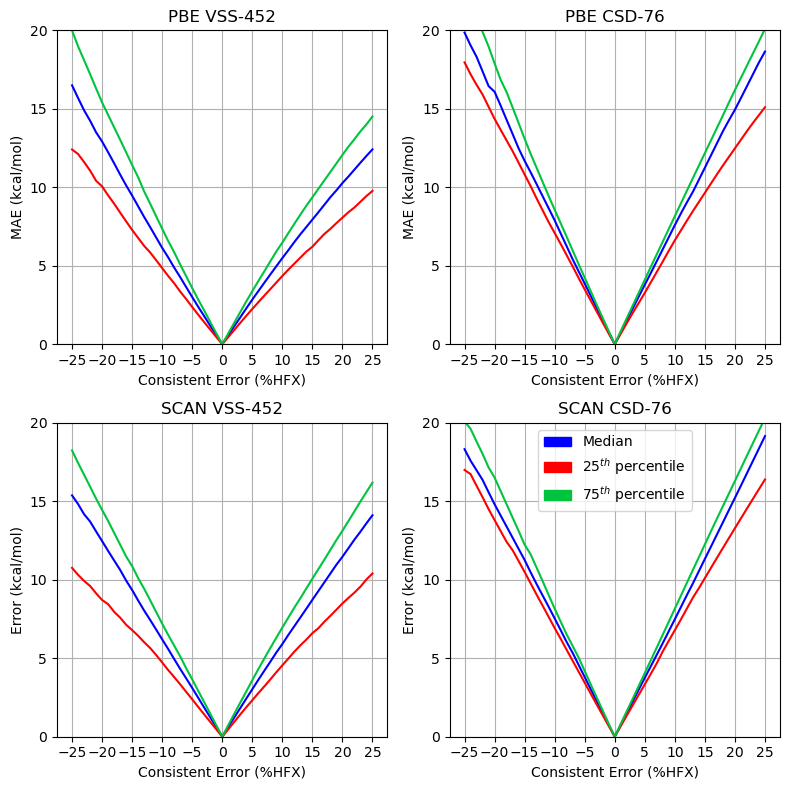

In [6]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(8,8))

minnum = -25
maxnum = 25
errrange = np.arange(minnum, maxnum+1, 1)

#ax[0,0].plot(errrange, AE_sys_error('vss', errrange)[0].mean(axis=0), color='#0000FF')
#ax[0,0].plot(errrange, AE_sys_error('vss', errrange)[0].max(axis=0), color='#FF0000')
#ax[0,0].plot(errrange, AE_sys_error('vss', errrange)[0].min(axis=0), color='#FF0000')
ax[0,0].plot(errrange, np.median(AE_sys_error('vss', errrange)[0], axis=0), color='#0000FF')
ax[0,0].plot(errrange, np.quantile(AE_sys_error('vss', errrange)[0], 0.25, axis=0), color='#FF0000')
ax[0,0].plot(errrange, np.quantile(AE_sys_error('vss', errrange)[0], 0.75, axis=0), color='#00C440')
ax[0,0].set_title('PBE VSS-452')
ax[0,0].set_xlabel('Consistent Error (%HFX)')
ax[0,0].set_ylabel('MAE (kcal/mol)')
ax[0,0].set_ylim((0,20))
ax[0,0].set_xticks(np.arange(minnum, maxnum+1, 5))
ax[0,0].set_yticks(np.arange(0, 21, 5))
ax[0,0].grid()

#ax[0,1].plot(errrange, AE_sys_error('csd', errrange)[0].mean(axis=0), color='#0000FF')
#ax[0,1].plot(errrange, AE_sys_error('csd', errrange)[0].max(axis=0), color='#FF0000')
#ax[0,1].plot(errrange, AE_sys_error('csd', errrange)[0].min(axis=0), color='#FF0000')
ax[0,1].plot(errrange, np.median(AE_sys_error('csd', errrange)[0], axis=0), color='#0000FF')
ax[0,1].plot(errrange, np.quantile(AE_sys_error('csd', errrange)[0], 0.25, axis=0), color='#FF0000')
ax[0,1].plot(errrange, np.quantile(AE_sys_error('csd', errrange)[0], 0.75, axis=0), color='#00C440')
ax[0,1].set_title('PBE CSD-76')
ax[0,1].set_xlabel('Consistent Error (%HFX)')
ax[0,1].set_ylabel('MAE (kcal/mol)')
ax[0,1].set_ylim((0,20))
ax[0,1].set_xticks(np.arange(minnum, maxnum+1, 5))
ax[0,1].set_yticks(np.arange(0, 21, 5))
ax[0,1].grid()

#ax[1,0].plot(errrange, AE_sys_error('vss', errrange)[1].mean(axis=0), color='#0000FF')
#ax[1,0].plot(errrange, AE_sys_error('vss', errrange)[1].max(axis=0), color='#FF0000')
#ax[1,0].plot(errrange, AE_sys_error('vss', errrange)[1].min(axis=0), color='#FF0000')
ax[1,0].plot(errrange, np.median(AE_sys_error('vss', errrange)[1], axis=0), color='#0000FF')
ax[1,0].plot(errrange, np.quantile(AE_sys_error('vss', errrange)[1], 0.25, axis=0), color='#FF0000')
ax[1,0].plot(errrange, np.quantile(AE_sys_error('vss', errrange)[1], 0.75, axis=0), color='#00C440')
ax[1,0].set_title('SCAN VSS-452')
ax[1,0].set_xlabel('Consistent Error (%HFX)')
ax[1,0].set_ylabel('Error (kcal/mol)')
ax[1,0].set_ylim((0,20))
ax[1,0].set_xticks(np.arange(minnum, maxnum+1, 5))
ax[1,0].set_yticks(np.arange(0, 21, 5))
ax[1,0].grid()

#ax[1,1].plot(errrange, AE_sys_error('csd', errrange)[1].mean(axis=0), color='#0000FF')
#ax[1,1].plot(errrange, AE_sys_error('csd', errrange)[1].max(axis=0), color='#FF0000')
#ax[1,1].plot(errrange, AE_sys_error('csd', errrange)[1].min(axis=0), color='#FF0000')
ax[1,1].plot(errrange, np.median(AE_sys_error('csd', errrange)[1], axis=0), color='#0000FF')
ax[1,1].plot(errrange, np.quantile(AE_sys_error('csd', errrange)[1], 0.25, axis=0), color='#FF0000')
ax[1,1].plot(errrange, np.quantile(AE_sys_error('csd', errrange)[1], 0.75, axis=0), color='#00C440')
ax[1,1].set_title('SCAN CSD-76')
ax[1,1].set_xlabel('Consistent Error (%HFX)')
ax[1,1].set_ylabel('Error (kcal/mol)')
ax[1,1].set_ylim((0,20))
ax[1,1].set_xticks(np.arange(minnum, maxnum+1, 5))
ax[1,1].set_yticks(np.arange(0, 21, 5))
ax[1,1].grid()

import matplotlib.patches as mpatches
patch0 = mpatches.Patch(color='#0000FF', label='Median')
patch1 = mpatches.Patch(color='#FF0000', label=r'25$^{th}$ percentile')
patch2 = mpatches.Patch(color='#00C440', label=r'75$^{th}$ percentile')
ax[1,1].legend(handles=[patch0, patch1, patch2])

fig.tight_layout()